In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

def train_mlp(mini_batch_x, mini_batch_y, learning_rate=0.1, decay_rate=0.95, num_iters=10000):
    nh = 30

    # initialization network weights
    w1 = np.random.randn(nh, 196)  # (30, 196)
    b1 = np.zeros((nh, 1))  # (30, 1)
    w2 = np.random.randn(10, nh)  # (10, 30)
    b2 = np.zeros((10, 1))  # (10, 1)

    k = 0
    losses = np.zeros((num_iters, 1))
    for iter in tqdm(range(num_iters), desc='Training MLP'):
        if (iter + 1) % 1000 == 0:
            learning_rate = decay_rate * learning_rate
        dl_dw1_batch = np.zeros((nh, 196))
        dl_db1_batch = np.zeros((nh, 1))
        dl_dw2_batch = np.zeros((10, nh))
        dl_db2_batch = np.zeros((10, 1))
        batch_size = mini_batch_x[k].shape[1]
        ll = np.zeros((batch_size, 1))
        for i in range(batch_size):
            x = mini_batch_x[k][:, [i]]
            y = mini_batch_y[k][:, [i]]

            # forward propagation
            h1 = fc(x, w1, b1)
            h2 = relu(h1)
            h3 = fc(h2, w2, b2)

            # loss computation (forward + backward)
            l, dl_dy = loss_cross_entropy_softmax(h3, y)
            ll[i] = l

            # backward propagation
            dl_dh2, dl_dw2, dl_db2 = fc_backward(dl_dy, h2, w2, b2)
            dl_dh1 = relu_backward(dl_dh2, h1)
            dl_dx, dl_dw1, dl_db1 = fc_backward(dl_dh1, x, w1, b1)

            # accumulate gradients
            dl_dw1_batch += dl_dw1
            dl_db1_batch += dl_db1
            dl_dw2_batch += dl_dw2
            dl_db2_batch += dl_db2

        losses[iter] = np.mean(ll)
        k = k + 1
        if k > len(mini_batch_x) - 1:
            k = 0

        # accumulate gradients
        w1 -= learning_rate * dl_dw1_batch / batch_size
        b1 -= learning_rate * dl_db1_batch / batch_size
        w2 -= learning_rate * dl_dw2_batch / batch_size
        b2 -= learning_rate * dl_db2_batch / batch_size

    return w1, b1, w2, b2, losses


def train_cnn(mini_batch_x, mini_batch_y, learning_rate=0.05, decay_rate=0.95, num_iters=10000):
    # initialization network weights
    w_conv = 0.1 * np.random.randn(3, 3, 1, 3)
    b_conv = np.zeros((3, 1))
    w_fc = 0.1 * np.random.randn(10, 147)
    b_fc = np.zeros((10, 1))

    k = 0
    losses = np.zeros((num_iters, 1))
    for iter in tqdm(range(num_iters), desc='Training CNN'):
        if (iter + 1) % 1000 == 0:
            learning_rate = decay_rate * learning_rate
            # print('iter {}/{}'.format(iter + 1, num_iters))

        dl_dw_conv_batch = np.zeros(w_conv.shape)
        dl_db_conv_batch = np.zeros(b_conv.shape)
        dl_dw_fc_batch = np.zeros(w_fc.shape)
        dl_db_fc_batch = np.zeros(b_fc.shape)
        batch_size = mini_batch_x[k].shape[1]
        ll = np.zeros((batch_size, 1))

        for i in range(batch_size):
            x = mini_batch_x[k][:, [i]].reshape((14, 14, 1))
            y = mini_batch_y[k][:, [i]]

            # forward propagation
            h1 = conv(x, w_conv, b_conv)  # (14, 14, 3)
            h2 = relu(h1)  # (14, 14, 3)
            h3 = pool2x2(h2)  # (7, 7, 3)
            h4 = flattening(h3)  # (147, 1)
            h5 = fc(h4, w_fc, b_fc)  # (10, 1)

            # loss computation (forward + backward)
            l, dl_dy = loss_cross_entropy_softmax(h5, y)
            ll[i] = l

            # backward propagation
            dl_dh4, dl_dw_fc, dl_db_fc = fc_backward(dl_dy, h4, w_fc, b_fc)  # (147, 1), (10, 147), (10, 1)
            dl_dh3 = flattening_backward(dl_dh4, h3)  # (7, 7, 3)
            dl_dh2 = pool2x2_backward(dl_dh3, h2)  # (14, 14, 3)
            dl_dh1 = relu_backward(dl_dh2, h1)  # (14, 14, 3)
            dl_dw_conv, dl_db_conv = conv_backward(dl_dh1, x, w_conv, b_conv)  # (3, 3, 1, 3), (3, 1)

            # accumulate gradients
            dl_dw_conv_batch += dl_dw_conv
            dl_db_conv_batch += dl_db_conv
            dl_dw_fc_batch += dl_dw_fc
            dl_db_fc_batch += dl_db_fc

        losses[iter] = np.mean(ll)
        k = k + 1
        if k > len(mini_batch_x) - 1:
            k = 0

        # update network weights
        w_conv -= learning_rate * dl_dw_conv_batch / batch_size
        b_conv -= learning_rate * dl_db_conv_batch / batch_size
        w_fc -= learning_rate * dl_dw_fc_batch / batch_size
        b_fc -= learning_rate * dl_db_fc_batch / batch_size

    return w_conv, b_conv, w_fc, b_fc, losses


def visualize_training_progress(losses, num_batches):
    # losses - (n_iter, 1)
    num_iters = losses.shape[0]
    num_epochs = math.ceil(num_iters / num_batches)
    losses_epoch = np.zeros((num_epochs, 1))
    losses_epoch[:num_epochs-1, 0] = np.mean(
        np.reshape(losses[:(num_epochs - 1)*num_batches], (num_epochs - 1, num_batches)), axis=1)
    losses_epoch[num_epochs-1] = np.mean(losses[(num_epochs - 1)*num_batches:])

    fig, axs = plt.subplots(1, 2, constrained_layout=True)
    axs[0].plot(range(num_iters), losses), axs[0].set_title('Training loss w.r.t. iteration')
    axs[0].set_xlabel('Iteration'), axs[0].set_ylabel('Loss'), axs[0].set_ylim([0, 5])
    axs[1].plot(range(num_epochs), losses_epoch), axs[1].set_title('Training loss w.r.t. epoch')
    axs[1].set_xlabel('Epoch'), axs[1].set_ylabel('Loss'), axs[1].set_ylim([0, 5])
    fig.suptitle('MLP Training Loss', fontsize=16)
    plt.show()


def infer_mlp(x, w1, b1, w2, b2):
    # x - (m, 1)
    h1 = fc(x, w1, b1)
    h2 = relu(h1)
    h3 = fc(h2, w2, b2)
    y = np.argmax(h3)
    return y


def infer_cnn(x, w_conv, b_conv, w_fc, b_fc):
    # x - (H(14), W(14), C_in(1))
    h1 = conv(x, w_conv, b_conv)  # (14, 14, 3)
    h2 = relu(h1)  # (14, 14, 3)
    h3 = pool2x2(h2)  # (7, 7, 3)
    h4 = flattening(h3)  # (147, 1)
    h5 = fc(h4, w_fc, b_fc)  # (10, 1)
    y = np.argmax(h5)
    return y


def compute_confusion_matrix_and_accuracy(pred, label, n_classes):
    # pred, label - (n, 1)
    accuracy = np.sum(pred == label) / len(label)
    confusion = np.zeros((n_classes, n_classes))
    for j in range(n_classes):
        for i in range(n_classes):
            # ground true is j but predicted to be i
            confusion[i, j] = np.sum(np.logical_and(label == j, pred == i)) / label.shape[0]
    return confusion, accuracy


def visualize_confusion_matrix(confusion, accuracy, label_classes):
    plt.title("Accuracy = {:.3f}".format(accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    plt.show()


def get_MNIST_data(resource_dir):
    with open(resource_dir + 'mnist_train.npz', 'rb') as f:
        d = np.load(f)
        image_train, label_train = d['img'], d['label']  # (12k, 14, 14), (12k, 1)
    with open(resource_dir + 'mnist_test.npz', 'rb') as f:
        d = np.load(f)
        image_test, label_test = d['img'], d['label']  # (2k, 14, 14), (2k, 1)

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

    return image_train, label_train, image_test, label_test, label_classes


# Change work_dir if the data is put in a different directory
work_dir = '/content/drive/MyDrive/3rd Semester Stuff/Computer Vision/hw5/'

image_train, label_train, image_test, label_test, label_classes = get_MNIST_data(work_dir)
image_train, image_test = image_train.reshape((-1, 196)).T / 255.0, image_test.reshape((-1, 196)).T / 255.0


(196, 12000)


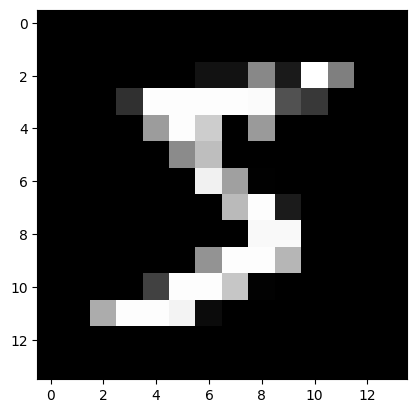

In [10]:
print(image_train.shape)
plt.imshow(image_train[:,0].reshape(14,14), cmap='gray')

In [11]:
def get_mini_batch(im_train, label_train, batch_size):
    train = np.vstack((im_train, label_train)).T
    np.random.shuffle(train)

    train_x = train[:,:-1]
    temp_y = train[:,-1].astype(int)

    train_y = np.zeros((temp_y.shape[0], 10))

    for i in range(temp_y.shape[0]):
        train_y[i,temp_y[i]] = 1

    mini_batch_x = []
    mini_batch_y = []

    for i in range(0, train.shape[0], 32):

        mini_batch_x.append(train_x[i:i+32,:].T)
        mini_batch_y.append(train_y[i:i+32,:].T)

    return mini_batch_x, mini_batch_y

mini_batch_x, mini_batch_y = get_mini_batch(image_train, label_train.T, batch_size=32)

(196, 32) (10, 32)
375 375


In [12]:
def fc(x, w, b):
    y = w @ x + b
    return y


def fc_backward(dl_dy, x, w, b):
    dy_dx = w.T
    dy_dw = x
    dy_db = 1

    dl_dx = dy_dx @ dl_dy
    dl_dw = dy_dw @ dl_dy.T
    dl_db = dl_dy

    return dl_dx, dl_dw.T, dl_db


def relu(x):
    return np.maximum(0, x)


def relu_backward(dl_dy, x):
    dl_dx = np.where(x > 0, dl_dy, 0)
    return dl_dx

#https://davidbieber.com/snippets/2020-12-12-derivative-of-softmax-and-the-softmax-cross-entropy-loss/
def loss_cross_entropy_softmax(x, y):
    softmax = np.exp(x)/ np.sum(np.exp(x), axis=0)
    l = - np.sum(y * np.log(softmax))
    dl_dx = softmax - y
    return l, dl_dx



Training MLP: 100%|██████████| 10000/10000 [01:04<00:00, 155.10it/s]


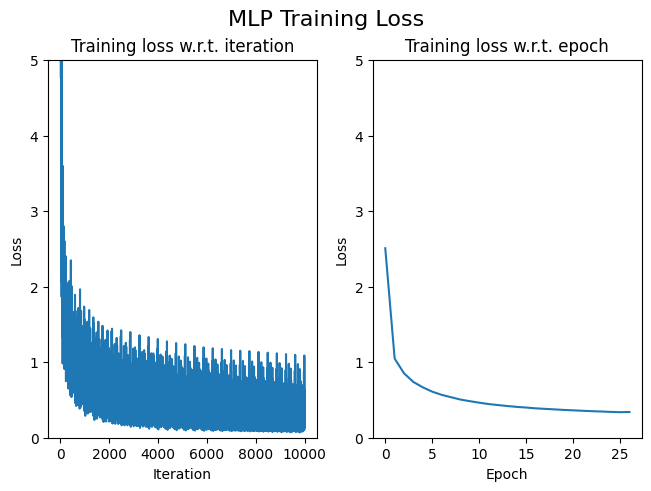

In [13]:
# Part 1: Multi-layer Perceptron
# train
w1, b1, w2, b2, losses = train_mlp(mini_batch_x, mini_batch_y,
                                    learning_rate=0.1, decay_rate=0.9, num_iters=10000)
visualize_training_progress(losses, len(mini_batch_x))
np.savez(work_dir + 'mlp.npz', w1=w1, b1=b1, w2=w2, b2=b2)

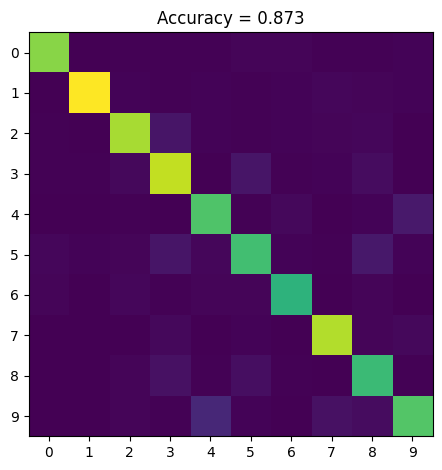

In [14]:
# test
pred_test = np.zeros_like(label_test)
for i in range(image_test.shape[1]):
    pred_test[i, 0] = infer_mlp(image_test[:, i].reshape((-1, 1)), w1, b1, w2, b2)
confusion, accuracy = compute_confusion_matrix_and_accuracy(pred_test, label_test, len(label_classes))
visualize_confusion_matrix(confusion, accuracy, label_classes)


In [15]:
def conv(x, w_conv, b_conv):
    H, W, C1 = x.shape
    h, w, C1, C2 = w_conv.shape

    p_h, p_w = (h-1)//2, (w-1)//2

    padding = ((p_h, p_h), (p_w, p_w), (0, 0))
    x_pad = np.pad(x, padding, mode='constant', constant_values=0)

    y = np.zeros((H,W,C2))

    for k in range(C2):
        for i in range(H):
            for j in range(W):
                temp = x_pad[i:i+h,j:j+w,:]
                y[i, j, k] = np.sum(temp * w_conv[:,:,:,k]) + b_conv[k,0]

    return y

#https://www.youtube.com/watch?v=z9hJzduHToc&ab_channel=far1din
def conv_backward(dl_dy, x, w_conv, b_conv):
    H, W, C1 = x.shape
    h, w, C1, C2 = w_conv.shape

    p_h, p_w = (h-1)//2, (w-1)//2
    padding = ((p_h, p_h), (p_w, p_w), (0, 0))
    x_pad = np.pad(x, padding, mode='constant', constant_values=0)

    dy_db = np.sum(dl_dy, axis=(0, 1)).reshape(-1, 1)

    dl_dw = np.zeros_like(w_conv)

    for i in range(C1):
        for j in range(C2):
            for k in range(H):
                for l in range(W):
                    dl_dw[:, :, i, j] += x_pad[k:k+h, l:l+w, i] * dl_dy[k, l, j]

    return dl_dw, dy_db


def pool2x2(x):
    H, W, C = x.shape
    y = np.zeros((H//2, W//2, C))
    for i in range(0, H, 2):
        for j in range(0, W, 2):
            for k in range(C):
                y[i//2,j//2,k] = np.max(x[i:i+2, j:j+2,k])
    return y


def pool2x2_backward(dl_dy, x):
    H, W, C = x.shape
    dl_dx = np.zeros((H, W, C))

    for i in range(0, H, 2):
        for j in range(0, W, 2):
            for k in range(C):
                l, m = np.unravel_index(np.argmax(x[i:i+2, j:j+2,k]), (2,2))
                dl_dx[i+l, j+m ,k] = dl_dy[i//2, j//2, k]

    return dl_dx


def flattening(x):
    return x.reshape((-1, 1))


def flattening_backward(dl_dy, x):
    return dl_dy.reshape(x.shape)

Training CNN: 100%|██████████| 1000/1000 [06:50<00:00,  2.43it/s]


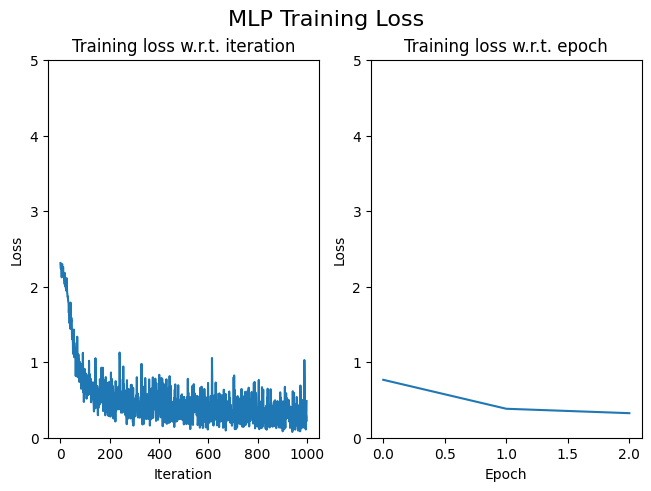

In [16]:
# Part 2: Convolutional Neural Network
# train
np.random.seed(0)
w_conv, b_conv, w_fc, b_fc, losses = train_cnn(mini_batch_x, mini_batch_y,
                                                learning_rate=0.1, decay_rate=0.9, num_iters=1000)
visualize_training_progress(losses, len(mini_batch_x))
np.savez(work_dir + 'cnn.npz', w_conv=w_conv, b_conv=b_conv, w_fc=w_fc, b_fc=b_fc)

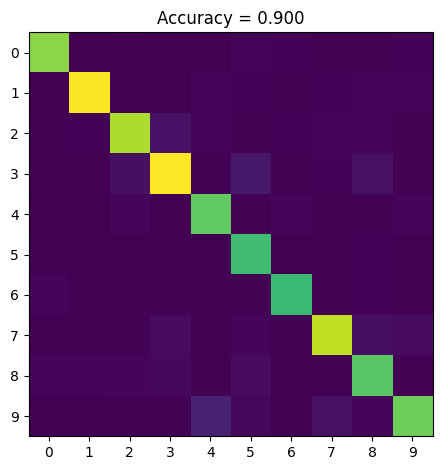

In [18]:
# test
pred_test = np.zeros_like(label_test)
for i in range(image_test.shape[1]):
    pred_test[i, 0] = infer_cnn(image_test[:, i].reshape((14, 14, 1)), w_conv, b_conv, w_fc, b_fc)
confusion, accuracy = compute_confusion_matrix_and_accuracy(pred_test, label_test, len(label_classes))
visualize_confusion_matrix(confusion, accuracy, label_classes)
